In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_pool_3_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=32, strides=1, 
                      activation='relu', input_shape=input_shape))
    
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=32*(2**int((i)/2)), strides=1, 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 170432)            0         
_________________________________________________________________
dropout (Dropout)            (None, 170432)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                2726928   
Total params: 2,727,760
Trainable params: 2,727,760
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1768, 32)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1744, 32)          25632     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 582, 32)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 558, 64)           51264     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2926 - acc: 0.2899
Epoch 00001: val_loss improved from inf to 1.89650, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_checkpoint/001-1.8965.hdf5
36805/36805 [==============================] - 15s 407us/sample - loss: 2.2926 - acc: 0.2899 - val_loss: 1.8965 - val_acc: 0.4356
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6824 - acc: 0.4910
Epoch 00002: val_loss improved from 1.89650 to 1.65628, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_checkpoint/002-1.6563.hdf5
36805/36805 [==============================] - 13s 361us/sample - loss: 1.6823 - acc: 0.4912 - val_loss: 1.6563 - val_acc: 0.4838
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.4300 - acc: 0.5680
Epoch 00003: val_loss improved from 1.65628 to 1.55347, s

Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3531 - acc: 0.9022
Epoch 00028: val_loss did not improve from 1.50780
36805/36805 [==============================] - 13s 360us/sample - loss: 0.3532 - acc: 0.9022 - val_loss: 1.9427 - val_acc: 0.5127
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3395 - acc: 0.9059
Epoch 00029: val_loss did not improve from 1.50780
36805/36805 [==============================] - 13s 351us/sample - loss: 0.3397 - acc: 0.9058 - val_loss: 1.9482 - val_acc: 0.5167
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3278 - acc: 0.9104
Epoch 00030: val_loss did not improve from 1.50780
36805/36805 [==============================] - 13s 353us/sample - loss: 0.3277 - acc: 0.9104 - val_loss: 1.9856 - val_acc: 0.5213
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3156 - acc: 0.9128
Epoch 00031: val_loss did not improve from 1.50780
36805/36805 [=====

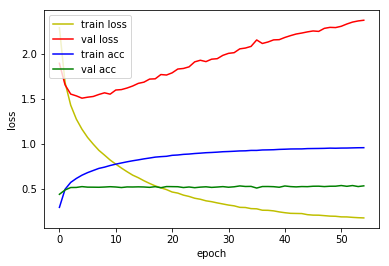

4815/4815 [==============================] - 1s 212us/sample - loss: 1.6051 - acc: 0.4874
Loss: 1.605065081077449 Accuracy: 0.4874351

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0908 - acc: 0.3214
Epoch 00001: val_loss improved from inf to 1.66562, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_checkpoint/001-1.6656.hdf5
36805/36805 [==============================] - 18s 498us/sample - loss: 2.0910 - acc: 0.3213 - val_loss: 1.6656 - val_acc: 0.4868
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5625 - acc: 0.5087
Epoch 00002: val_loss improved from 1.66562 to 1.46129, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_checkpoint/002-1.4613.hdf5
36805/36805 [==============================] - 18s 483us/sample - loss: 1.5626 - acc: 0.5086 - val_loss: 1.4613 - val_acc: 0.5467
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3471 - acc: 0.8940
Epoch 00027: val_loss did not improve from 1.19742
36805/36805 [==============================] - 18s 477us/sample - loss: 0.3471 - acc: 0.8941 - val_loss: 1.3137 - val_acc: 0.6634
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3345 - acc: 0.8954
Epoch 00028: val_loss did not improve from 1.19742
36805/36805 [==============================] - 17s 474us/sample - loss: 0.3345 - acc: 0.8954 - val_loss: 1.3630 - val_acc: 0.6587
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3202 - acc: 0.9021
Epoch 00029: val_loss did not improve from 1.19742
36805/36805 [==============================] - 17s 474us/sample - loss: 0.3202 - acc: 0.9021 - val_loss: 1.3373 - val_acc: 0.6620
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3098 - acc: 0.9045
Epoch 00030: val_loss did not improve from 1.19742
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1360 - acc: 0.9605
Epoch 00057: val_loss did not improve from 1.19742
36805/36805 [==============================] - 18s 482us/sample - loss: 0.1360 - acc: 0.9605 - val_loss: 1.5816 - val_acc: 0.6788
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1381 - acc: 0.9589
Epoch 00058: val_loss did not improve from 1.19742
36805/36805 [==============================] - 18s 483us/sample - loss: 0.1380 - acc: 0.9589 - val_loss: 1.5603 - val_acc: 0.6816
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1280 - acc: 0.9643
Epoch 00059: val_loss did not improve from 1.19742
36805/36805 [==============================] - 18s 480us/sample - loss: 0.1280 - acc: 0.9643 - val_loss: 1.5903 - val_acc: 0.6723
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1268 - acc: 0.9627
Epoch 00060: val_loss did not improve from 1.19742
36805/36805 [=====

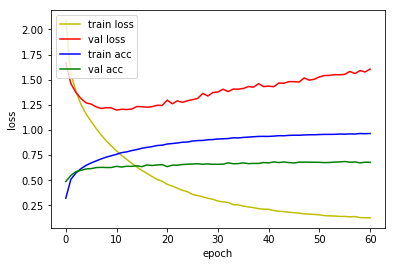

4815/4815 [==============================] - 1s 276us/sample - loss: 1.3208 - acc: 0.5948
Loss: 1.3208386398921503 Accuracy: 0.59480786

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0766 - acc: 0.3172
Epoch 00001: val_loss improved from inf to 1.63943, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/001-1.6394.hdf5
36805/36805 [==============================] - 21s 560us/sample - loss: 2.0765 - acc: 0.3172 - val_loss: 1.6394 - val_acc: 0.4894
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5878 - acc: 0.4993
Epoch 00002: val_loss improved from 1.63943 to 1.42978, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/002-1.4298.hdf5
36805/36805 [==============================] - 20s 538us/sample - loss: 1.5878 - acc: 0.4993 - val_loss: 1.4298 - val_acc: 0.5472
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4499 - acc: 0.8696
Epoch 00024: val_loss did not improve from 0.66277
36805/36805 [==============================] - 20s 534us/sample - loss: 0.4499 - acc: 0.8696 - val_loss: 0.6781 - val_acc: 0.8085
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4309 - acc: 0.8738
Epoch 00025: val_loss improved from 0.66277 to 0.65086, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/025-0.6509.hdf5
36805/36805 [==============================] - 20s 536us/sample - loss: 0.4309 - acc: 0.8738 - val_loss: 0.6509 - val_acc: 0.8206
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4131 - acc: 0.8787
Epoch 00026: val_loss did not improve from 0.65086
36805/36805 [==============================] - 20s 534us/sample - loss: 0.4131 - acc: 0.8787 - val_loss: 0.6543 - val_acc: 0.8183
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1631 - acc: 0.9511
Epoch 00053: val_loss did not improve from 0.64483
36805/36805 [==============================] - 20s 533us/sample - loss: 0.1631 - acc: 0.9510 - val_loss: 0.7148 - val_acc: 0.8339
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1594 - acc: 0.9520
Epoch 00054: val_loss did not improve from 0.64483
36805/36805 [==============================] - 19s 521us/sample - loss: 0.1594 - acc: 0.9520 - val_loss: 0.7362 - val_acc: 0.8300
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1512 - acc: 0.9534
Epoch 00055: val_loss did not improve from 0.64483
36805/36805 [==============================] - 20s 533us/sample - loss: 0.1512 - acc: 0.9534 - val_loss: 0.7156 - val_acc: 0.8355
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1545 - acc: 0.9541
Epoch 00056: val_loss did not improve from 0.64483
36805/36805 [=====

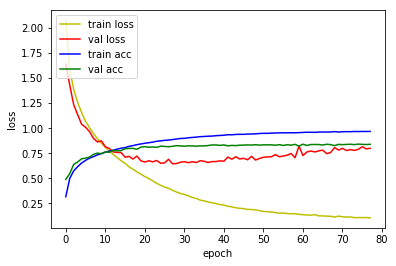

4815/4815 [==============================] - 1s 308us/sample - loss: 0.7446 - acc: 0.7886
Loss: 0.7446282528890132 Accuracy: 0.7885774

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1147 - acc: 0.3021
Epoch 00001: val_loss improved from inf to 1.61972, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_checkpoint/001-1.6197.hdf5
36805/36805 [==============================] - 23s 624us/sample - loss: 2.1146 - acc: 0.3021 - val_loss: 1.6197 - val_acc: 0.4950
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5100 - acc: 0.5271
Epoch 00002: val_loss improved from 1.61972 to 1.34590, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_checkpoint/002-1.3459.hdf5
36805/36805 [==============================] - 21s 579us/sample - loss: 1.5098 - acc: 0.5272 - val_loss: 1.3459 - val_acc: 0.5788
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2784 - acc: 0.9132
Epoch 00024: val_loss improved from 0.37634 to 0.36322, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_checkpoint/024-0.3632.hdf5
36805/36805 [==============================] - 21s 574us/sample - loss: 0.2785 - acc: 0.9131 - val_loss: 0.3632 - val_acc: 0.9038
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2743 - acc: 0.9153
Epoch 00025: val_loss did not improve from 0.36322
36805/36805 [==============================] - 21s 576us/sample - loss: 0.2743 - acc: 0.9153 - val_loss: 0.3634 - val_acc: 0.9026
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2549 - acc: 0.9213
Epoch 00026: val_loss did not improve from 0.36322
36805/36805 [==============================] - 21s 573us/sample - loss: 0.2549 - acc: 0.9213 - val_loss: 0.3781 - val_acc: 0.9008
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9754
Epoch 00081: val_loss did not improve from 0.33850
36805/36805 [==============================] - 21s 568us/sample - loss: 0.0762 - acc: 0.9754 - val_loss: 0.3933 - val_acc: 0.9245
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0675 - acc: 0.9785
Epoch 00082: val_loss did not improve from 0.33850
36805/36805 [==============================] - 21s 558us/sample - loss: 0.0675 - acc: 0.9785 - val_loss: 0.4015 - val_acc: 0.9248
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9770
Epoch 00083: val_loss did not improve from 0.33850
36805/36805 [==============================] - 21s 568us/sample - loss: 0.0712 - acc: 0.9770 - val_loss: 0.3798 - val_acc: 0.9297
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9761
Epoch 00084: val_loss did not improve from 0.33850
36805/36805 [=====

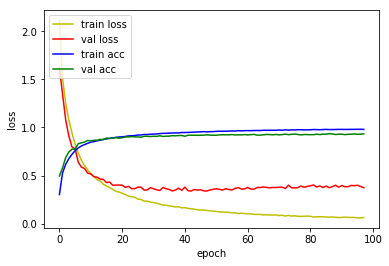

4815/4815 [==============================] - 2s 326us/sample - loss: 0.4169 - acc: 0.8953
Loss: 0.41691894648850025 Accuracy: 0.8953271

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2949 - acc: 0.2401
Epoch 00001: val_loss improved from inf to 1.53332, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/001-1.5333.hdf5
36805/36805 [==============================] - 24s 652us/sample - loss: 2.2948 - acc: 0.2402 - val_loss: 1.5333 - val_acc: 0.5220
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4776 - acc: 0.5197
Epoch 00002: val_loss improved from 1.53332 to 1.15680, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/002-1.1568.hdf5
36805/36805 [==============================] - 22s 592us/sample - loss: 1.4776 - acc: 0.5197 - val_loss: 1.1568 - val_acc: 0.6452
Epoch 3/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2370 - acc: 0.9228
Epoch 00023: val_loss did not improve from 0.21944
36805/36805 [==============================] - 22s 588us/sample - loss: 0.2371 - acc: 0.9228 - val_loss: 0.2211 - val_acc: 0.9371
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2262 - acc: 0.9281
Epoch 00024: val_loss improved from 0.21944 to 0.20302, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/024-0.2030.hdf5
36805/36805 [==============================] - 22s 593us/sample - loss: 0.2262 - acc: 0.9281 - val_loss: 0.2030 - val_acc: 0.9399
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9274
Epoch 00025: val_loss improved from 0.20302 to 0.19994, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/025-0.1999.hdf5
36805/36805 [==============================] - 22s 587us/sample - loss: 0.2231 - acc: 0.9274 - val_loss: 0.19

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9624
Epoch 00050: val_loss did not improve from 0.17183
36805/36805 [==============================] - 22s 593us/sample - loss: 0.1125 - acc: 0.9624 - val_loss: 0.1933 - val_acc: 0.9481
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9639
Epoch 00051: val_loss did not improve from 0.17183
36805/36805 [==============================] - 22s 592us/sample - loss: 0.1037 - acc: 0.9639 - val_loss: 0.1815 - val_acc: 0.9490
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9648
Epoch 00052: val_loss did not improve from 0.17183
36805/36805 [==============================] - 22s 590us/sample - loss: 0.1053 - acc: 0.9648 - val_loss: 0.1843 - val_acc: 0.9495
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9650
Epoch 00053: val_loss did not improve from 0.17183
36805/36805 [=====

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9842
Epoch 00109: val_loss did not improve from 0.17158
36805/36805 [==============================] - 22s 588us/sample - loss: 0.0466 - acc: 0.9842 - val_loss: 0.1962 - val_acc: 0.9585
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9845
Epoch 00110: val_loss did not improve from 0.17158
36805/36805 [==============================] - 22s 588us/sample - loss: 0.0478 - acc: 0.9845 - val_loss: 0.2082 - val_acc: 0.9564
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9837
Epoch 00111: val_loss did not improve from 0.17158
36805/36805 [==============================] - 22s 587us/sample - loss: 0.0464 - acc: 0.9837 - val_loss: 0.1989 - val_acc: 0.9576
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9842
Epoch 00112: val_loss did not improve from 0.17158
36805/36805 [=

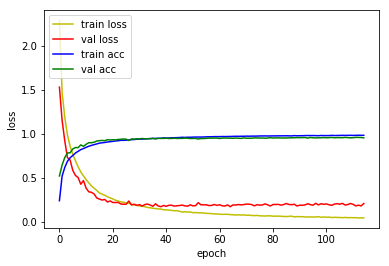

4815/4815 [==============================] - 2s 360us/sample - loss: 0.2320 - acc: 0.9375
Loss: 0.23200334134750525 Accuracy: 0.937487

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1871 - acc: 0.2745
Epoch 00001: val_loss improved from inf to 1.48169, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_checkpoint/001-1.4817.hdf5
36805/36805 [==============================] - 26s 698us/sample - loss: 2.1871 - acc: 0.2745 - val_loss: 1.4817 - val_acc: 0.5220
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3689 - acc: 0.5462
Epoch 00002: val_loss improved from 1.48169 to 0.97682, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_checkpoint/002-0.9768.hdf5
36805/36805 [==============================] - 23s 618us/sample - loss: 1.3688 - acc: 0.5463 - val_loss: 0.9768 - val_acc: 0.7042
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1642 - acc: 0.9465
Epoch 00024: val_loss did not improve from 0.16852
36805/36805 [==============================] - 23s 616us/sample - loss: 0.1642 - acc: 0.9466 - val_loss: 0.1759 - val_acc: 0.9483
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1593 - acc: 0.9474
Epoch 00025: val_loss did not improve from 0.16852
36805/36805 [==============================] - 23s 617us/sample - loss: 0.1593 - acc: 0.9474 - val_loss: 0.1878 - val_acc: 0.9462
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1523 - acc: 0.9505
Epoch 00026: val_loss did not improve from 0.16852
36805/36805 [==============================] - 23s 614us/sample - loss: 0.1523 - acc: 0.9505 - val_loss: 0.1826 - val_acc: 0.9495
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9514
Epoch 00027: val_loss improved from 0.16852 to 0.16494, saving model 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9746
Epoch 00053: val_loss did not improve from 0.16472
36805/36805 [==============================] - 22s 610us/sample - loss: 0.0724 - acc: 0.9746 - val_loss: 0.1814 - val_acc: 0.9553
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9759
Epoch 00054: val_loss did not improve from 0.16472
36805/36805 [==============================] - 22s 607us/sample - loss: 0.0691 - acc: 0.9759 - val_loss: 0.2022 - val_acc: 0.9529
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9752
Epoch 00055: val_loss did not improve from 0.16472
36805/36805 [==============================] - 23s 613us/sample - loss: 0.0709 - acc: 0.9752 - val_loss: 0.1836 - val_acc: 0.9567
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9775
Epoch 00056: val_loss did not improve from 0.16472
36805/36805 [=====

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9848
Epoch 00083: val_loss did not improve from 0.16472
36805/36805 [==============================] - 23s 613us/sample - loss: 0.0455 - acc: 0.9848 - val_loss: 0.2193 - val_acc: 0.9560
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9848
Epoch 00084: val_loss did not improve from 0.16472
36805/36805 [==============================] - 23s 614us/sample - loss: 0.0456 - acc: 0.9848 - val_loss: 0.2150 - val_acc: 0.9534
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9843
Epoch 00085: val_loss did not improve from 0.16472
36805/36805 [==============================] - 23s 611us/sample - loss: 0.0481 - acc: 0.9842 - val_loss: 0.2126 - val_acc: 0.9548
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9856
Epoch 00086: val_loss did not improve from 0.16472
36805/36805 [=====

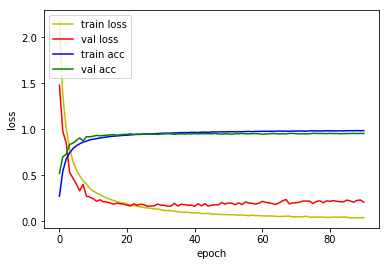

4815/4815 [==============================] - 2s 367us/sample - loss: 0.2384 - acc: 0.9364
Loss: 0.23835274931178782 Accuracy: 0.9364486



In [10]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_32_DO'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_32_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_32_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 170432)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 170432)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2726928   
Total params: 2,727,760
Trainable params: 2,727,760
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 1s 232us/sample - loss: 1.6051 - acc: 0.4874


4815/4815 [==============================] - 2s 394us/sample - loss: 0.2320 - acc: 0.9375
Loss: 0.23200334134750525 Accuracy: 0.937487

1D_CNN_6_only_conv_pool_3_ch_32_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1768, 32)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1744, 32)          25632     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (N

In [12]:
def build_1d_cnn_only_conv_pool_3_ch_32_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=32, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=32*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [13]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_32_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2726928   
Total params: 2,727,888
Trainable params: 2,727,824
Non-trainable params: 64
_________________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_15 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 5302, 32)          128       
_________________________________________________________________
activation_16 (Activation)   (None, 5302, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2629 - acc: 0.3440
Epoch 00001: val_loss improved from inf to 1.81280, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_BN_checkpoint/001-1.8128.hdf5
36805/36805 [==============================] - 24s 660us/sample - loss: 2.2628 - acc: 0.3440 - val_loss: 1.8128 - val_acc: 0.4277
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3120 - acc: 0.5901
Epoch 00002: val_loss improved from 1.81280 to 1.76745, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_BN_checkpoint/002-1.7675.hdf5
36805/36805 [==============================] - 20s 543us/sample - loss: 1.3120 - acc: 0.5900 - val_loss: 1.7675 - val_acc: 0.4826
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9699 - acc: 0.6964
Epoch 00003: val_loss did not improve from 1.76745
36805/36805 [==============================] - 20s 541

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9903
Epoch 00030: val_loss did not improve from 1.76745
36805/36805 [==============================] - 20s 540us/sample - loss: 0.0556 - acc: 0.9903 - val_loss: 3.8025 - val_acc: 0.4864
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0900 - acc: 0.9795
Epoch 00031: val_loss did not improve from 1.76745
36805/36805 [==============================] - 20s 538us/sample - loss: 0.0900 - acc: 0.9795 - val_loss: 3.8081 - val_acc: 0.4719
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9887
Epoch 00032: val_loss did not improve from 1.76745
36805/36805 [==============================] - 20s 539us/sample - loss: 0.0605 - acc: 0.9887 - val_loss: 3.7230 - val_acc: 0.4952
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9845
Epoch 00033: val_loss did not improve from 1.76745
36805/36805 [=====

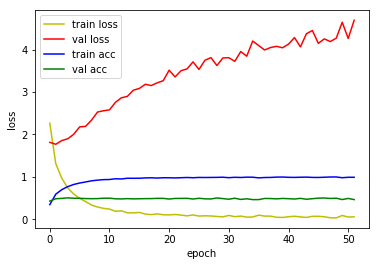

4815/4815 [==============================] - 2s 375us/sample - loss: 1.8675 - acc: 0.4548
Loss: 1.867456780391071 Accuracy: 0.45482865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8993 - acc: 0.4034
Epoch 00001: val_loss improved from inf to 1.61983, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_BN_checkpoint/001-1.6198.hdf5
36805/36805 [==============================] - 34s 927us/sample - loss: 1.8993 - acc: 0.4034 - val_loss: 1.6198 - val_acc: 0.4589
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2379 - acc: 0.6114
Epoch 00002: val_loss improved from 1.61983 to 1.32758, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_BN_checkpoint/002-1.3276.hdf5
36805/36805 [==============================] - 28s 758us/sample - loss: 1.2379 - acc: 0.6114 - val_loss: 1.3276 - val_acc: 0.5802
Epoch 3/500
36736/36805 [============================>.] - ETA: 0

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0613 - acc: 0.9868
Epoch 00029: val_loss did not improve from 1.31039
36805/36805 [==============================] - 28s 748us/sample - loss: 0.0614 - acc: 0.9868 - val_loss: 2.2893 - val_acc: 0.5772
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9874
Epoch 00030: val_loss did not improve from 1.31039
36805/36805 [==============================] - 27s 747us/sample - loss: 0.0571 - acc: 0.9874 - val_loss: 2.0799 - val_acc: 0.6136
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9929
Epoch 00031: val_loss did not improve from 1.31039
36805/36805 [==============================] - 28s 748us/sample - loss: 0.0392 - acc: 0.9929 - val_loss: 2.3429 - val_acc: 0.5854
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9904
Epoch 00032: val_loss did not improve from 1.31039
36805/36805 [=====

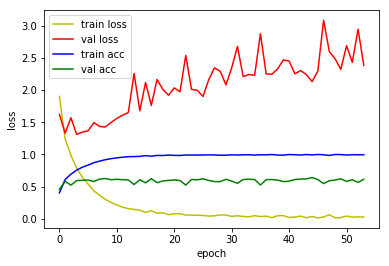

4815/4815 [==============================] - 2s 449us/sample - loss: 1.3751 - acc: 0.5913
Loss: 1.3750804191437838 Accuracy: 0.59127724

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7405 - acc: 0.4565
Epoch 00001: val_loss improved from inf to 1.47204, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_BN_checkpoint/001-1.4720.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.7407 - acc: 0.4565 - val_loss: 1.4720 - val_acc: 0.5097
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1317 - acc: 0.6528
Epoch 00002: val_loss improved from 1.47204 to 1.03084, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_BN_checkpoint/002-1.0308.hdf5
36805/36805 [==============================] - 34s 914us/sample - loss: 1.1319 - acc: 0.6527 - val_loss: 1.0308 - val_acc: 0.6818
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9991
Epoch 00058: val_loss did not improve from 0.92889
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0120 - acc: 0.9991 - val_loss: 1.2412 - val_acc: 0.7720
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9988
Epoch 00059: val_loss did not improve from 0.92889
36805/36805 [==============================] - 33s 904us/sample - loss: 0.0125 - acc: 0.9988 - val_loss: 1.3465 - val_acc: 0.7694

1D_CNN_3_only_conv_pool_3_ch_32_BN Model


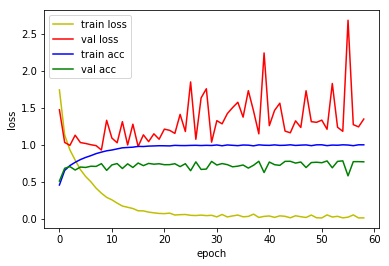

4815/4815 [==============================] - 3s 534us/sample - loss: 1.0425 - acc: 0.7053
Loss: 1.0424887828118827 Accuracy: 0.7052959

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6319 - acc: 0.4843
Epoch 00001: val_loss improved from inf to 1.30294, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_BN_checkpoint/001-1.3029.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.6320 - acc: 0.4843 - val_loss: 1.3029 - val_acc: 0.5875
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9734 - acc: 0.7079
Epoch 00002: val_loss improved from 1.30294 to 1.01505, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_BN_checkpoint/002-1.0150.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.9733 - acc: 0.7079 - val_loss: 1.0150 - val_acc: 0.6902
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9876
Epoch 00027: val_loss did not improve from 0.38513
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0582 - acc: 0.9876 - val_loss: 0.5543 - val_acc: 0.8593
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9833
Epoch 00028: val_loss did not improve from 0.38513
36805/36805 [==============================] - 37s 996us/sample - loss: 0.0695 - acc: 0.9833 - val_loss: 0.4782 - val_acc: 0.8800
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9899
Epoch 00029: val_loss did not improve from 0.38513
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0478 - acc: 0.9899 - val_loss: 0.4399 - val_acc: 0.8919
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9914
Epoch 00030: val_loss did not improve from 0.38513
36805/36805 [=========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9992
Epoch 00057: val_loss did not improve from 0.38513
36805/36805 [==============================] - 37s 994us/sample - loss: 0.0073 - acc: 0.9992 - val_loss: 0.4304 - val_acc: 0.9059
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9931
Epoch 00058: val_loss did not improve from 0.38513
36805/36805 [==============================] - 37s 994us/sample - loss: 0.0289 - acc: 0.9931 - val_loss: 0.4381 - val_acc: 0.9017
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9948
Epoch 00059: val_loss did not improve from 0.38513
36805/36805 [==============================] - 37s 997us/sample - loss: 0.0214 - acc: 0.9947 - val_loss: 0.4285 - val_acc: 0.9068
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9945
Epoch 00060: val_loss did not improve from 0.38513
36805/36805 [=====

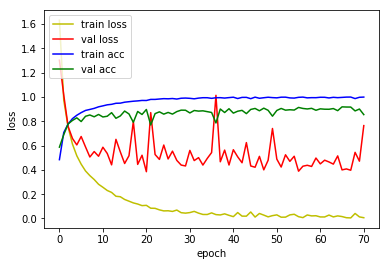

4815/4815 [==============================] - 3s 525us/sample - loss: 0.5014 - acc: 0.8810
Loss: 0.5014188018048169 Accuracy: 0.8809969

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4788 - acc: 0.5401
Epoch 00001: val_loss improved from inf to 1.13009, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_BN_checkpoint/001-1.1301.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4789 - acc: 0.5401 - val_loss: 1.1301 - val_acc: 0.6506
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7275 - acc: 0.7878
Epoch 00002: val_loss improved from 1.13009 to 0.74830, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_BN_checkpoint/002-0.7483.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.7277 - acc: 0.7877 - val_loss: 0.7483 - val_acc: 0.7731
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9919
Epoch 00027: val_loss did not improve from 0.23118
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0340 - acc: 0.9919 - val_loss: 0.3102 - val_acc: 0.9187
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9871
Epoch 00028: val_loss did not improve from 0.23118
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0469 - acc: 0.9871 - val_loss: 0.3597 - val_acc: 0.9124
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9880
Epoch 00029: val_loss improved from 0.23118 to 0.21187, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_BN_checkpoint/029-0.2119.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0456 - acc: 0.9880 - val_loss: 0.2119 - val_acc: 0.9455
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9968
Epoch 00056: val_loss did not improve from 0.20862
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0133 - acc: 0.9968 - val_loss: 0.2219 - val_acc: 0.9497
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9933
Epoch 00057: val_loss did not improve from 0.20862
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0238 - acc: 0.9933 - val_loss: 0.3594 - val_acc: 0.9199
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9958
Epoch 00058: val_loss improved from 0.20862 to 0.20218, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_BN_checkpoint/058-0.2022.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0180 - acc: 0.9958 - val_loss: 0.2022 - val_acc: 0.9495
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - lo

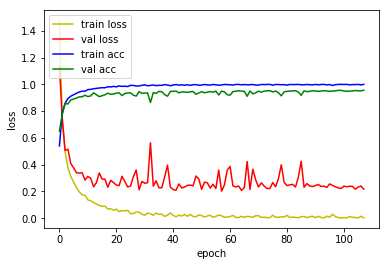

4815/4815 [==============================] - 3s 629us/sample - loss: 0.2789 - acc: 0.9279
Loss: 0.27887315152373515 Accuracy: 0.9279335

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3642 - acc: 0.5795
Epoch 00001: val_loss improved from inf to 1.13378, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_BN_checkpoint/001-1.1338.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.3642 - acc: 0.5795 - val_loss: 1.1338 - val_acc: 0.6471
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6146 - acc: 0.8240
Epoch 00002: val_loss improved from 1.13378 to 0.51656, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_BN_checkpoint/002-0.5166.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.6146 - acc: 0.8239 - val_loss: 0.5166 - val_acc: 0.8477
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9903
Epoch 00025: val_loss did not improve from 0.17449
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0381 - acc: 0.9903 - val_loss: 0.1809 - val_acc: 0.9455
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9881
Epoch 00026: val_loss did not improve from 0.17449
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0470 - acc: 0.9881 - val_loss: 0.2275 - val_acc: 0.9411
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9934
Epoch 00027: val_loss did not improve from 0.17449
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0290 - acc: 0.9934 - val_loss: 0.2570 - val_acc: 0.9390
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9911
Epoch 00028: val_loss did not improve from 0.17449
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9977
Epoch 00054: val_loss did not improve from 0.15557
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0108 - acc: 0.9977 - val_loss: 0.1849 - val_acc: 0.9532
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9960
Epoch 00055: val_loss did not improve from 0.15557
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0155 - acc: 0.9960 - val_loss: 0.2458 - val_acc: 0.9399
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9969
Epoch 00056: val_loss did not improve from 0.15557
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0132 - acc: 0.9969 - val_loss: 0.2042 - val_acc: 0.9462
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9983
Epoch 00057: val_loss did not improve from 0.15557
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9943
Epoch 00084: val_loss did not improve from 0.15557
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0203 - acc: 0.9943 - val_loss: 0.1828 - val_acc: 0.9583

1D_CNN_6_only_conv_pool_3_ch_32_BN Model


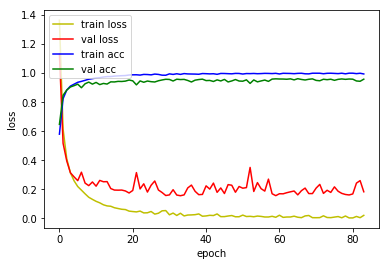

4815/4815 [==============================] - 3s 660us/sample - loss: 0.1931 - acc: 0.9547
Loss: 0.1930593069640848 Accuracy: 0.9547248



In [14]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_32_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_32_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_32_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_32_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_21 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_21 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                2726928   
Total params: 2,727,888
Trainable params: 2,727,824
Non-trainable params: 64
_______________________

4815/4815 [==============================] - 3s 634us/sample - loss: 0.5014 - acc: 0.8810
Loss: 0.5014188018048169 Accuracy: 0.8809969

1D_CNN_5_only_conv_pool_3_ch_32_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_31 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_31 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_32 (B (N

In [16]:
def build_1d_cnn_only_conv_pool_3_ch_32_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=32, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=32*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [17]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 170432)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                2726928   
Total para

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_52 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_52 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_53 (B (None, 5302, 32)          128       
_________________________________________________________________
activation_53 (Activation)   (None, 5302, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4079 - acc: 0.3004
Epoch 00001: val_loss improved from inf to 1.82802, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.8280.hdf5
36805/36805 [==============================] - 35s 941us/sample - loss: 2.4079 - acc: 0.3004 - val_loss: 1.8280 - val_acc: 0.4526
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4545 - acc: 0.5361
Epoch 00002: val_loss improved from 1.82802 to 1.72836, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.7284.hdf5
36805/36805 [==============================] - 21s 581us/sample - loss: 1.4545 - acc: 0.5360 - val_loss: 1.7284 - val_acc: 0.4829
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1512 - acc: 0.6320
Epoch 00003: val_loss did not improve from 1.72836
36805/36805 [==============================] - 2

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1995 - acc: 0.9400
Epoch 00030: val_loss did not improve from 1.72836
36805/36805 [==============================] - 21s 577us/sample - loss: 0.1995 - acc: 0.9400 - val_loss: 2.8612 - val_acc: 0.5262
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1827 - acc: 0.9438
Epoch 00031: val_loss did not improve from 1.72836
36805/36805 [==============================] - 21s 578us/sample - loss: 0.1827 - acc: 0.9438 - val_loss: 3.0231 - val_acc: 0.5071
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1902 - acc: 0.9419
Epoch 00032: val_loss did not improve from 1.72836
36805/36805 [==============================] - 21s 577us/sample - loss: 0.1902 - acc: 0.9419 - val_loss: 3.0709 - val_acc: 0.5073
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1780 - acc: 0.9455
Epoch 00033: val_loss did not improve from 1.72836
36805/36805 [=====

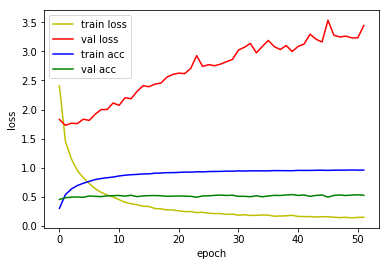

4815/4815 [==============================] - 3s 543us/sample - loss: 1.8137 - acc: 0.4453
Loss: 1.813713441385287 Accuracy: 0.4452752

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1439 - acc: 0.3414
Epoch 00001: val_loss improved from inf to 1.68158, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.6816.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.1439 - acc: 0.3414 - val_loss: 1.6816 - val_acc: 0.4430
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4656 - acc: 0.5327
Epoch 00002: val_loss improved from 1.68158 to 1.32910, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.3291.hdf5
36805/36805 [==============================] - 28s 764us/sample - loss: 1.4659 - acc: 0.5326 - val_loss: 1.3291 - val_acc: 0.5779
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2317 - acc: 0.9237
Epoch 00028: val_loss did not improve from 1.10691
36805/36805 [==============================] - 28s 763us/sample - loss: 0.2316 - acc: 0.9237 - val_loss: 1.6699 - val_acc: 0.6352
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2259 - acc: 0.9250
Epoch 00029: val_loss did not improve from 1.10691
36805/36805 [==============================] - 28s 763us/sample - loss: 0.2260 - acc: 0.9249 - val_loss: 1.4460 - val_acc: 0.6702
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2237 - acc: 0.9264
Epoch 00030: val_loss did not improve from 1.10691
36805/36805 [==============================] - 28s 763us/sample - loss: 0.2236 - acc: 0.9265 - val_loss: 1.3427 - val_acc: 0.6944
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2123 - acc: 0.9308
Epoch 00031: val_loss did not improve from 1.10691
36805/36805 [=====


1D_CNN_2_only_conv_pool_3_ch_32_DO_BN Model


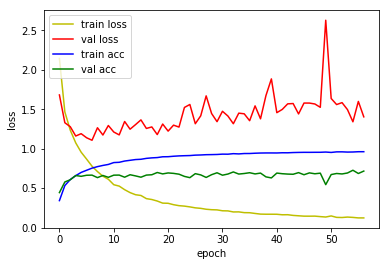

4815/4815 [==============================] - 3s 658us/sample - loss: 1.2178 - acc: 0.6399
Loss: 1.2177560783744725 Accuracy: 0.6398754

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1185 - acc: 0.3624
Epoch 00001: val_loss improved from inf to 1.60423, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.6042.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.1186 - acc: 0.3624 - val_loss: 1.6042 - val_acc: 0.4680
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3862 - acc: 0.5731
Epoch 00002: val_loss improved from 1.60423 to 1.19724, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.1972.hdf5
36805/36805 [==============================] - 34s 925us/sample - loss: 1.3863 - acc: 0.5730 - val_loss: 1.1972 - val_acc: 0.6366
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9706
Epoch 00057: val_loss did not improve from 0.68749
36805/36805 [==============================] - 34s 923us/sample - loss: 0.0942 - acc: 0.9706 - val_loss: 1.1196 - val_acc: 0.7685
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9753
Epoch 00058: val_loss did not improve from 0.68749
36805/36805 [==============================] - 34s 922us/sample - loss: 0.0841 - acc: 0.9753 - val_loss: 0.9123 - val_acc: 0.8001
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9749
Epoch 00059: val_loss did not improve from 0.68749
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0824 - acc: 0.9749 - val_loss: 1.0823 - val_acc: 0.7848
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0838 - acc: 0.9752
Epoch 00060: val_loss did not improve from 0.68749
36805/36805 [=====

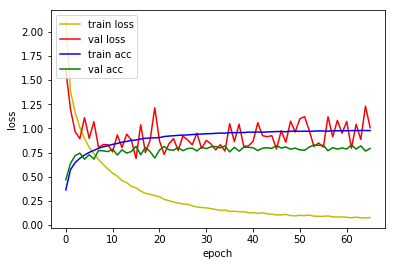

4815/4815 [==============================] - 4s 764us/sample - loss: 0.7857 - acc: 0.7782
Loss: 0.7857196288564371 Accuracy: 0.7781932

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1143 - acc: 0.3552
Epoch 00001: val_loss improved from inf to 1.46620, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.4662.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 2.1142 - acc: 0.3552 - val_loss: 1.4662 - val_acc: 0.5232
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2680 - acc: 0.6023
Epoch 00002: val_loss improved from 1.46620 to 0.97520, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-0.9752.hdf5
36805/36805 [==============================] - 36s 989us/sample - loss: 1.2680 - acc: 0.6024 - val_loss: 0.9752 - val_acc: 0.7119
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9400
Epoch 00026: val_loss did not improve from 0.35972
36805/36805 [==============================] - 36s 989us/sample - loss: 0.1938 - acc: 0.9400 - val_loss: 0.4780 - val_acc: 0.8796
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1881 - acc: 0.9413
Epoch 00027: val_loss did not improve from 0.35972
36805/36805 [==============================] - 37s 992us/sample - loss: 0.1881 - acc: 0.9413 - val_loss: 0.4987 - val_acc: 0.8800
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1849 - acc: 0.9419
Epoch 00028: val_loss did not improve from 0.35972
36805/36805 [==============================] - 36s 987us/sample - loss: 0.1849 - acc: 0.9419 - val_loss: 0.4680 - val_acc: 0.8742
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9437
Epoch 00029: val_loss did not improve from 0.35972
36805/36805 [=====

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9707
Epoch 00054: val_loss did not improve from 0.29676
36805/36805 [==============================] - 36s 987us/sample - loss: 0.0891 - acc: 0.9707 - val_loss: 0.3854 - val_acc: 0.9043
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0849 - acc: 0.9730
Epoch 00055: val_loss did not improve from 0.29676
36805/36805 [==============================] - 36s 988us/sample - loss: 0.0853 - acc: 0.9729 - val_loss: 0.3802 - val_acc: 0.9075
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9660
Epoch 00056: val_loss did not improve from 0.29676
36805/36805 [==============================] - 36s 989us/sample - loss: 0.1080 - acc: 0.9659 - val_loss: 0.4816 - val_acc: 0.8854
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9710
Epoch 00057: val_loss did not improve from 0.29676
36805/36805 [=====

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9812
Epoch 00084: val_loss did not improve from 0.29676
36805/36805 [==============================] - 37s 992us/sample - loss: 0.0595 - acc: 0.9812 - val_loss: 0.4005 - val_acc: 0.9157
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9852
Epoch 00085: val_loss did not improve from 0.29676
36805/36805 [==============================] - 36s 990us/sample - loss: 0.0476 - acc: 0.9852 - val_loss: 0.5496 - val_acc: 0.8863
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9837
Epoch 00086: val_loss did not improve from 0.29676
36805/36805 [==============================] - 36s 991us/sample - loss: 0.0547 - acc: 0.9837 - val_loss: 0.3708 - val_acc: 0.9222
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9834
Epoch 00087: val_loss did not improve from 0.29676
36805/36805 [=====

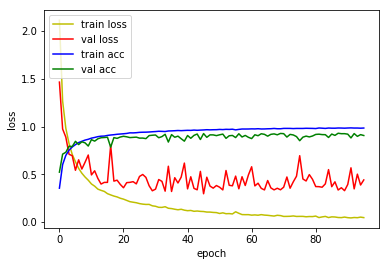

4815/4815 [==============================] - 3s 708us/sample - loss: 0.4222 - acc: 0.8987
Loss: 0.4222374154337965 Accuracy: 0.89865005

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0052 - acc: 0.3818
Epoch 00001: val_loss improved from inf to 1.33163, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.3316.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 2.0052 - acc: 0.3818 - val_loss: 1.3316 - val_acc: 0.5618
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0889 - acc: 0.6580
Epoch 00002: val_loss improved from 1.33163 to 0.77628, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-0.7763.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 1.0890 - acc: 0.6580 - val_loss: 0.7763 - val_acc: 0.7605
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1210 - acc: 0.9615
Epoch 00025: val_loss did not improve from 0.20015
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.1210 - acc: 0.9615 - val_loss: 0.2262 - val_acc: 0.9434
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1022 - acc: 0.9664
Epoch 00026: val_loss did not improve from 0.20015
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.1022 - acc: 0.9664 - val_loss: 0.2693 - val_acc: 0.9259
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1010 - acc: 0.9676
Epoch 00027: val_loss improved from 0.20015 to 0.17179, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_BN_checkpoint/027-0.1718.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.1010 - acc: 0.9676 - val_loss: 0.1718 - val_acc: 0.9511
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s -

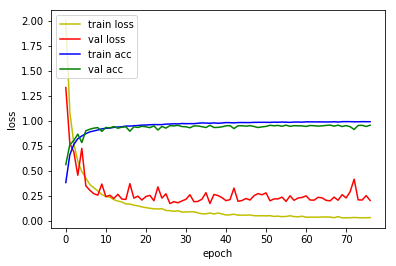

4815/4815 [==============================] - 4s 743us/sample - loss: 0.2146 - acc: 0.9387
Loss: 0.21462220662850828 Accuracy: 0.9387331

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9300 - acc: 0.4094
Epoch 00001: val_loss improved from inf to 1.15332, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.1533.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 1.9298 - acc: 0.4095 - val_loss: 1.1533 - val_acc: 0.6355
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9089 - acc: 0.7159
Epoch 00002: val_loss improved from 1.15332 to 0.53926, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-0.5393.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.9088 - acc: 0.7159 - val_loss: 0.5393 - val_acc: 0.8428
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0934 - acc: 0.9708
Epoch 00026: val_loss improved from 0.15851 to 0.15596, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_BN_checkpoint/026-0.1560.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0935 - acc: 0.9708 - val_loss: 0.1560 - val_acc: 0.9569
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9725
Epoch 00027: val_loss did not improve from 0.15596
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0854 - acc: 0.9725 - val_loss: 0.1890 - val_acc: 0.9511
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0763 - acc: 0.9768
Epoch 00028: val_loss did not improve from 0.15596
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0763 - acc: 0.9768 - val_loss: 0.1591 - val_acc: 0.9548
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9895
Epoch 00055: val_loss did not improve from 0.12944
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0352 - acc: 0.9895 - val_loss: 0.1394 - val_acc: 0.9639
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9906
Epoch 00056: val_loss did not improve from 0.12944
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0324 - acc: 0.9906 - val_loss: 0.1485 - val_acc: 0.9634
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9896
Epoch 00057: val_loss did not improve from 0.12944
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0335 - acc: 0.9896 - val_loss: 0.1928 - val_acc: 0.9548
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9898
Epoch 00058: val_loss did not improve from 0.12944
36805/36805 [===========

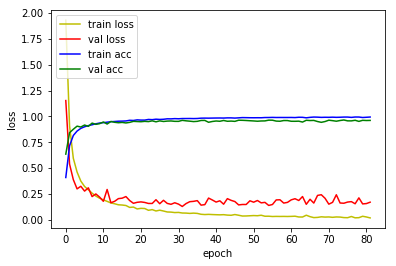

4815/4815 [==============================] - 4s 920us/sample - loss: 0.1903 - acc: 0.9533
Loss: 0.19034799152205728 Accuracy: 0.95327103



In [18]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_32_DO_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
for i in range(1, 7):
    model_name = '1D_CNN_only_conv_{}_conv_pool_3_ch_32_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_32_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_63 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_63 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 5326, 32)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 170432)            0         
_________________________________________________________________
dense_30 (Dense)             (N

4815/4815 [==============================] - 4s 933us/sample - loss: 0.4222 - acc: 0.8987
Loss: 0.4222374154337965 Accuracy: 0.89865005

1D_CNN_5_only_conv_pool_3_ch_32_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_115 (Conv1D)          (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 15976, 32)         128       
_________________________________________________________________
activation_73 (Activation)   (None, 15976, 32)         0         
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 5326, 32)          0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_74 (